In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
input_file = 'SimpleTree_mudst.root'
events = ur.open("%s:data"%(input_file))
arrays = events.arrays()

posx = arrays['Cal_hit_posx']
posy = arrays['Cal_hit_posy']
posz = arrays['Cal_hit_posz']
energy = arrays['Cal_hit_energy']
detid = arrays['Cal_detid']

adcsum = arrays['Cal_adcsum']
detid = arrays['Cal_detid']

cut_primary = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^ (arrays['Cal_detid']==1) ^ (arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_HCAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_ECAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^ (arrays['Cal_detid']==1))


xcut = posx[cut_primary]
ycut = posy[cut_primary]
zcut = posz[cut_primary]
ecut = energy[cut_primary]
idcut = detid[cut_primary]

xHcal = posx[cut_HCAL]
yHcal = posy[cut_HCAL]
zHcal = posz[cut_HCAL]
eHcal = energy[cut_HCAL]

xEcal = posx[cut_ECAL]
yEcal = posy[cut_ECAL]
zEcal = posz[cut_ECAL]
eEcal = energy[cut_ECAL]

In [3]:
norms = np.sqrt(xcut**2 + ycut**2 + zcut**2)
px = (xcut / norms) * ecut
py = (ycut / norms) * ecut
pz = (zcut / norms) * ecut
ex = np.abs(px)

momenta = ak.zip(
    {
        "px": ak.Array(px),
        "py": ak.Array(py),
        "pz": ak.Array(pz),
        "E": ak.Array(ecut),
        "det": ak.Array(idcut)
    }
)

allLorentz = ak.Array(momenta, with_name="Momentum4D", behavior=ak.behavior)

print(allLorentz)

[[{px: -0.0266, py: 0.0141, pz: 0.516, E: 0.517, det: 0}, ..., {...}], ...]


In [4]:
# Define the jet definition
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.0)

# Cluster the particles into jets
cluster = fastjet.ClusterSequence(allLorentz, jetdef)
inc_jets = cluster.inclusive_jets()

# Define a function to calculate the x, y, and z components of the momentum vector
def momentum_xyz(px, py, pz):
    norm = np.sqrt(px**2 + py**2 + pz**2)
    x = px / norm
    y = py / norm
    z = pz / norm
    return x, y, z

# Define a function to calculate the eta coordinate
def eta(r, z):
    theta = abs(np.arctan(r / z))
    return -1 * np.log(np.tan(theta / 2))

def inverse_eta(eta, z):
    y = z * (2 * np.exp(-eta)) / (1 - np.exp(-2*eta))
    return y

def phi(x,y):
    return np.arctan2(y, x)

0.10000094


<ErrorbarContainer object of 3 artists>

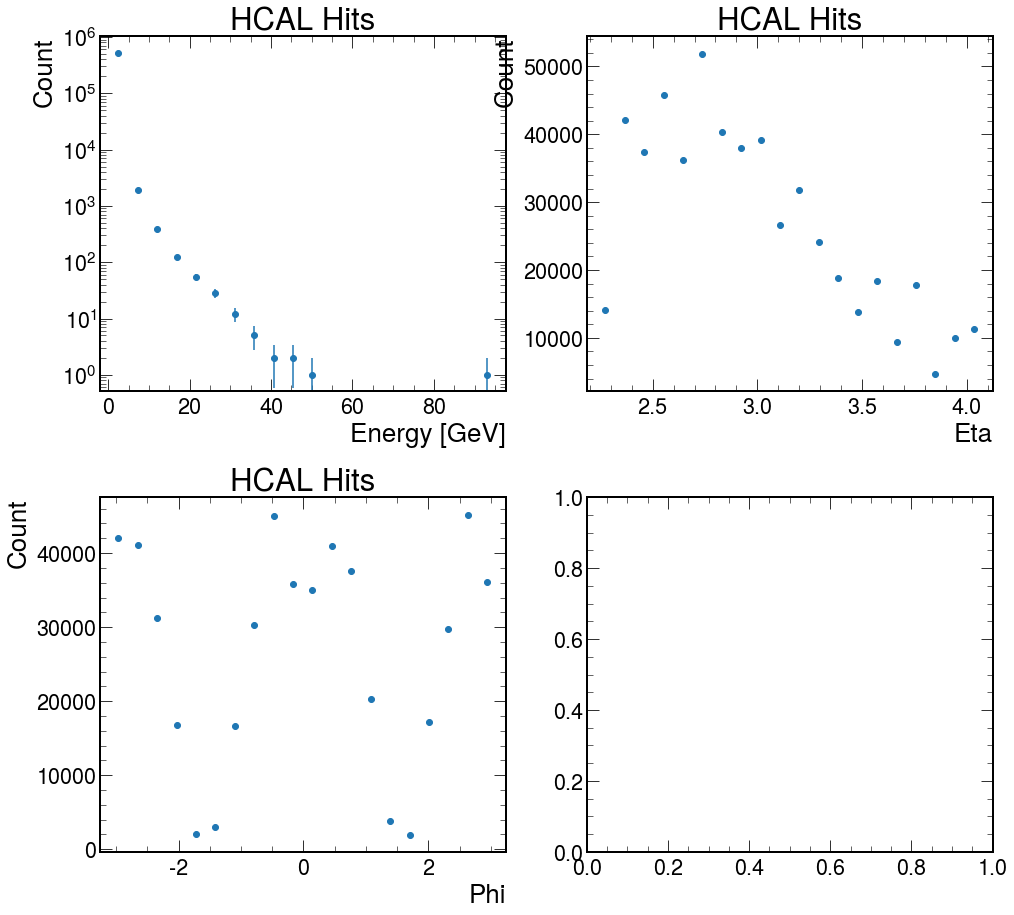

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'hspace': 0.3})
R=0.4
plt.sca(axs[0][0])

hist, bin_edges = np.histogram(ak.flatten(eHcal),bins=20)
print(min(ak.flatten(eHcal)))
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Energy [GeV]")
plt.ylabel("Count")
plt.yscale("log")
plt.title("HCAL Hits")

plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")

plt.sca(axs[0][1])

etaHcal = eta(np.sqrt(xHcal**2 + yHcal**2), 806)

hist, bin_edges = np.histogram(ak.flatten(etaHcal),bins=20)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Eta")
plt.ylabel("Count")
plt.title("HCAL Hits")

plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")

plt.sca(axs[1][0])

phiHcal = phi(xHcal, yHcal)

hist, bin_edges = np.histogram(ak.flatten(phiHcal),bins=20)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Phi")
plt.ylabel("Count")
plt.title("HCAL Hits")

plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")



<ErrorbarContainer object of 3 artists>

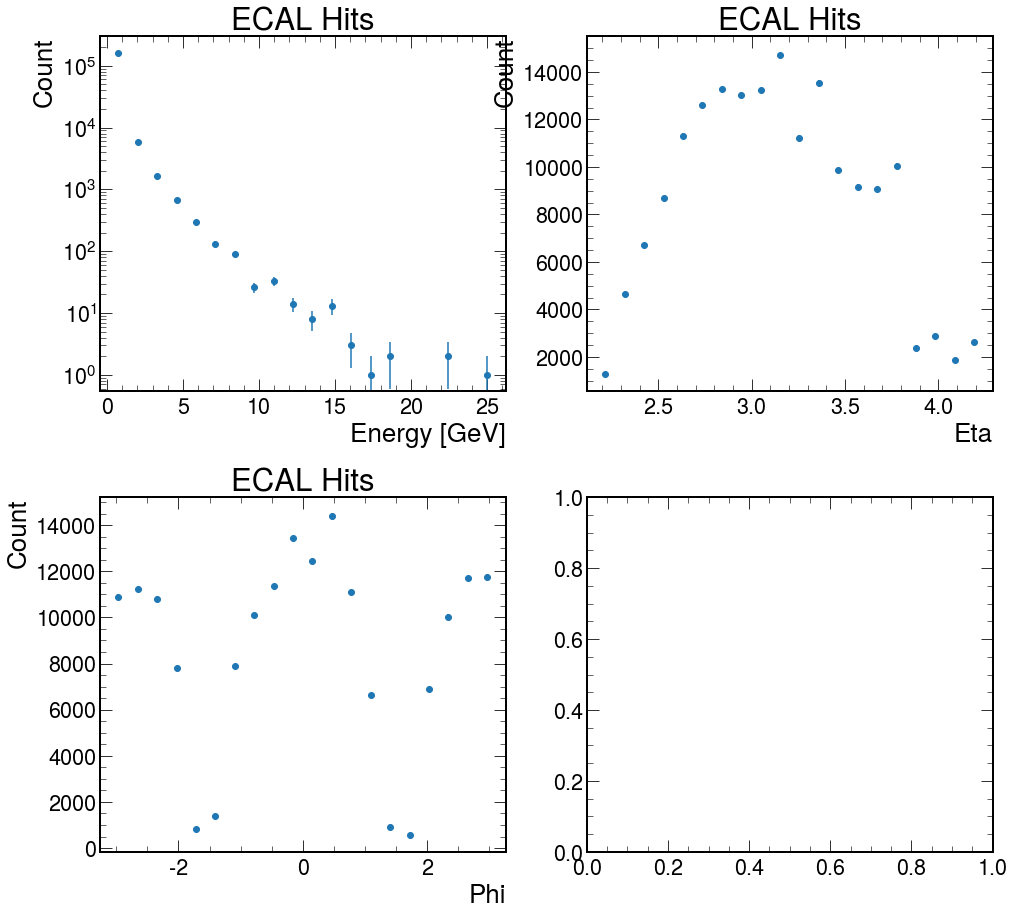

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'hspace': 0.3})
R=0.4
plt.sca(axs[0][0])

hist, bin_edges = np.histogram(ak.flatten(eEcal),bins=20)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Energy [GeV]")
plt.ylabel("Count")
plt.yscale("log")
plt.title("ECAL Hits")

plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")

plt.sca(axs[0][1])

etaEcal = eta(np.sqrt(xEcal**2 + yEcal**2), 724)

hist, bin_edges = np.histogram(ak.flatten(etaEcal),bins=20)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Eta")
plt.ylabel("Count")
plt.title("ECAL Hits")

plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")

plt.sca(axs[1][0])

phiEcal = phi(xEcal, yEcal)

hist, bin_edges = np.histogram(ak.flatten(phiEcal),bins=20)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Phi")
plt.ylabel("Count")
plt.title("ECAL Hits")

plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")



In [7]:
# Mask the jets based on the energy of their constituents
mask = inc_jets.E > 0
inc_jets_masked = inc_jets[mask]

# Extract the x, y, and z components of the momentum vector
jetX, jetY, jetE = [], [], []
jetXAll, jetYAll, jetEAll, jetEta = [], [], [], []


x, y, z = momentum_xyz(inc_jets_masked.px, inc_jets_masked.py, inc_jets_masked.pz)
    
jetE = inc_jets_masked.E
jetXH = 806 * x / z
jetYH = 806 * y / z

jetXE = 724 * x / z
jetYE = 724 * y / z

jetEta = eta(np.sqrt(x**2 + y**2), z)
jetPhi = phi(x,y)

highJet = []

for i in range(len(jetE)):
    for j in range(len(jetE[i])):
        if jetE[i][j] >= 0:
            highJet.append(i)
            
highJet = list(set(highJet))


In [8]:
print(inc_jets)

[[{px: -0.00442, py: -0.000522, pz: 0.132, E: 0.132}, ..., {px: ..., ...}], ...]


(-100.0, 100.0)

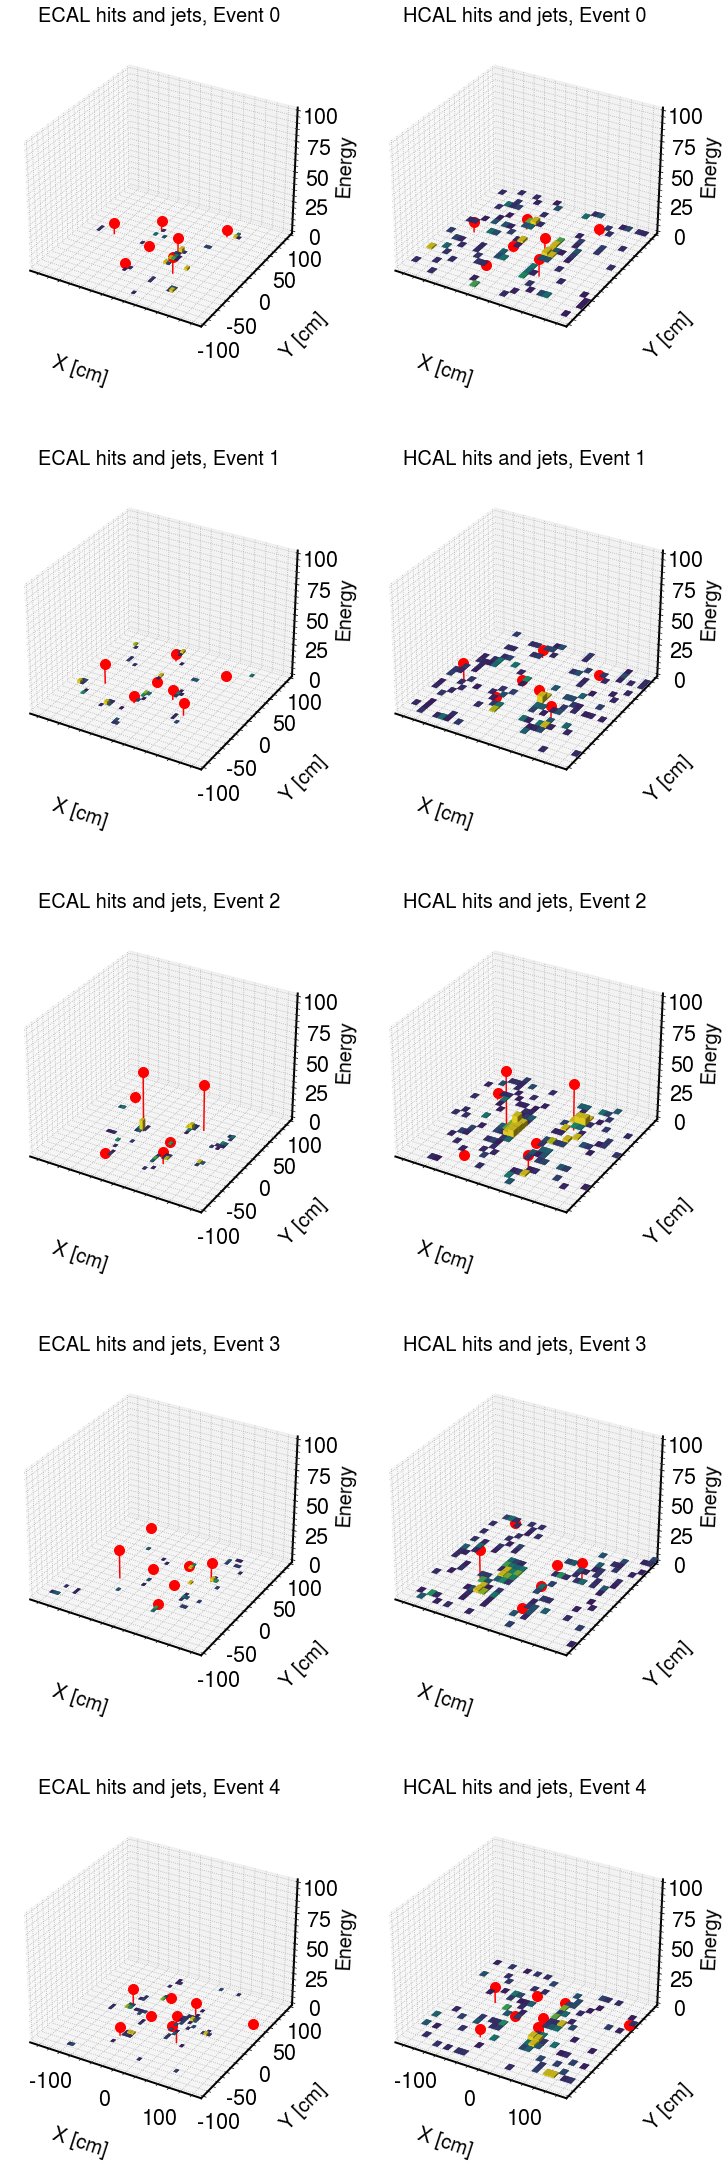

In [9]:
n = 5

fig, axs = plt.subplots(nrows=n, ncols=2, subplot_kw={'projection': '3d'}, figsize=(12, 8*n), gridspec_kw={'hspace': 0.1}, sharey=True,sharex=True)

inferno = plt.get_cmap('viridis')
cmap = plt.get_cmap('viridis')



for i in range(n):
    #evt = highJet[i]
    evt=i
    ax = axs[i][0]
    ax.set_title(f'ECAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.bar3d(np.array(xEcal[evt]), np.array(yEcal[evt]), 0, 5.5694733, 5.572006, np.array(eEcal[evt]), color=[cmap(k) for k in np.array(eEcal[evt])])
    ax.set_zlim(0, 100)
   
    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)
    ax.set_zlabel('Energy', fontsize=20)

    ax.yaxis.labelpad=30
    ax.xaxis.labelpad=30
    ax.zaxis.labelpad=10

    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXE[evt][j]
        y_pos = jetYE[evt][j]
        z_pos = jetE[evt][j]
        ax.scatter(x_pos, y_pos, z_pos, s=100, color='red', marker='o')
        ax.plot([x_pos, x_pos], [y_pos, y_pos], [0, z_pos], color='red')

    
    ax = axs[i][1]
    ax.set_title(f'HCAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.bar3d(np.array(xHcal[evt]), np.array(yHcal[evt]), 0, 9.985443, 9.98999, np.array(eHcal[evt]), color=[cmap(k) for k in np.array(eHcal[evt])])

    ax.set_zlim(0, 100)
    
    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)
    ax.set_zlabel('Energy', fontsize=20)

    ax.yaxis.labelpad=30
    ax.xaxis.labelpad=30
    ax.zaxis.labelpad=10

    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXH[evt][j]
        y_pos = jetYH[evt][j]
        z_pos = jetE[evt][j]
        ax.scatter(x_pos, y_pos, z_pos, s=100, color='red', marker='o')
        ax.plot([x_pos, x_pos], [y_pos, y_pos], [0, z_pos], color='red')

#plt.tight_layout()
plt.xlim(-150,150)
plt.ylim(-100,100)


/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


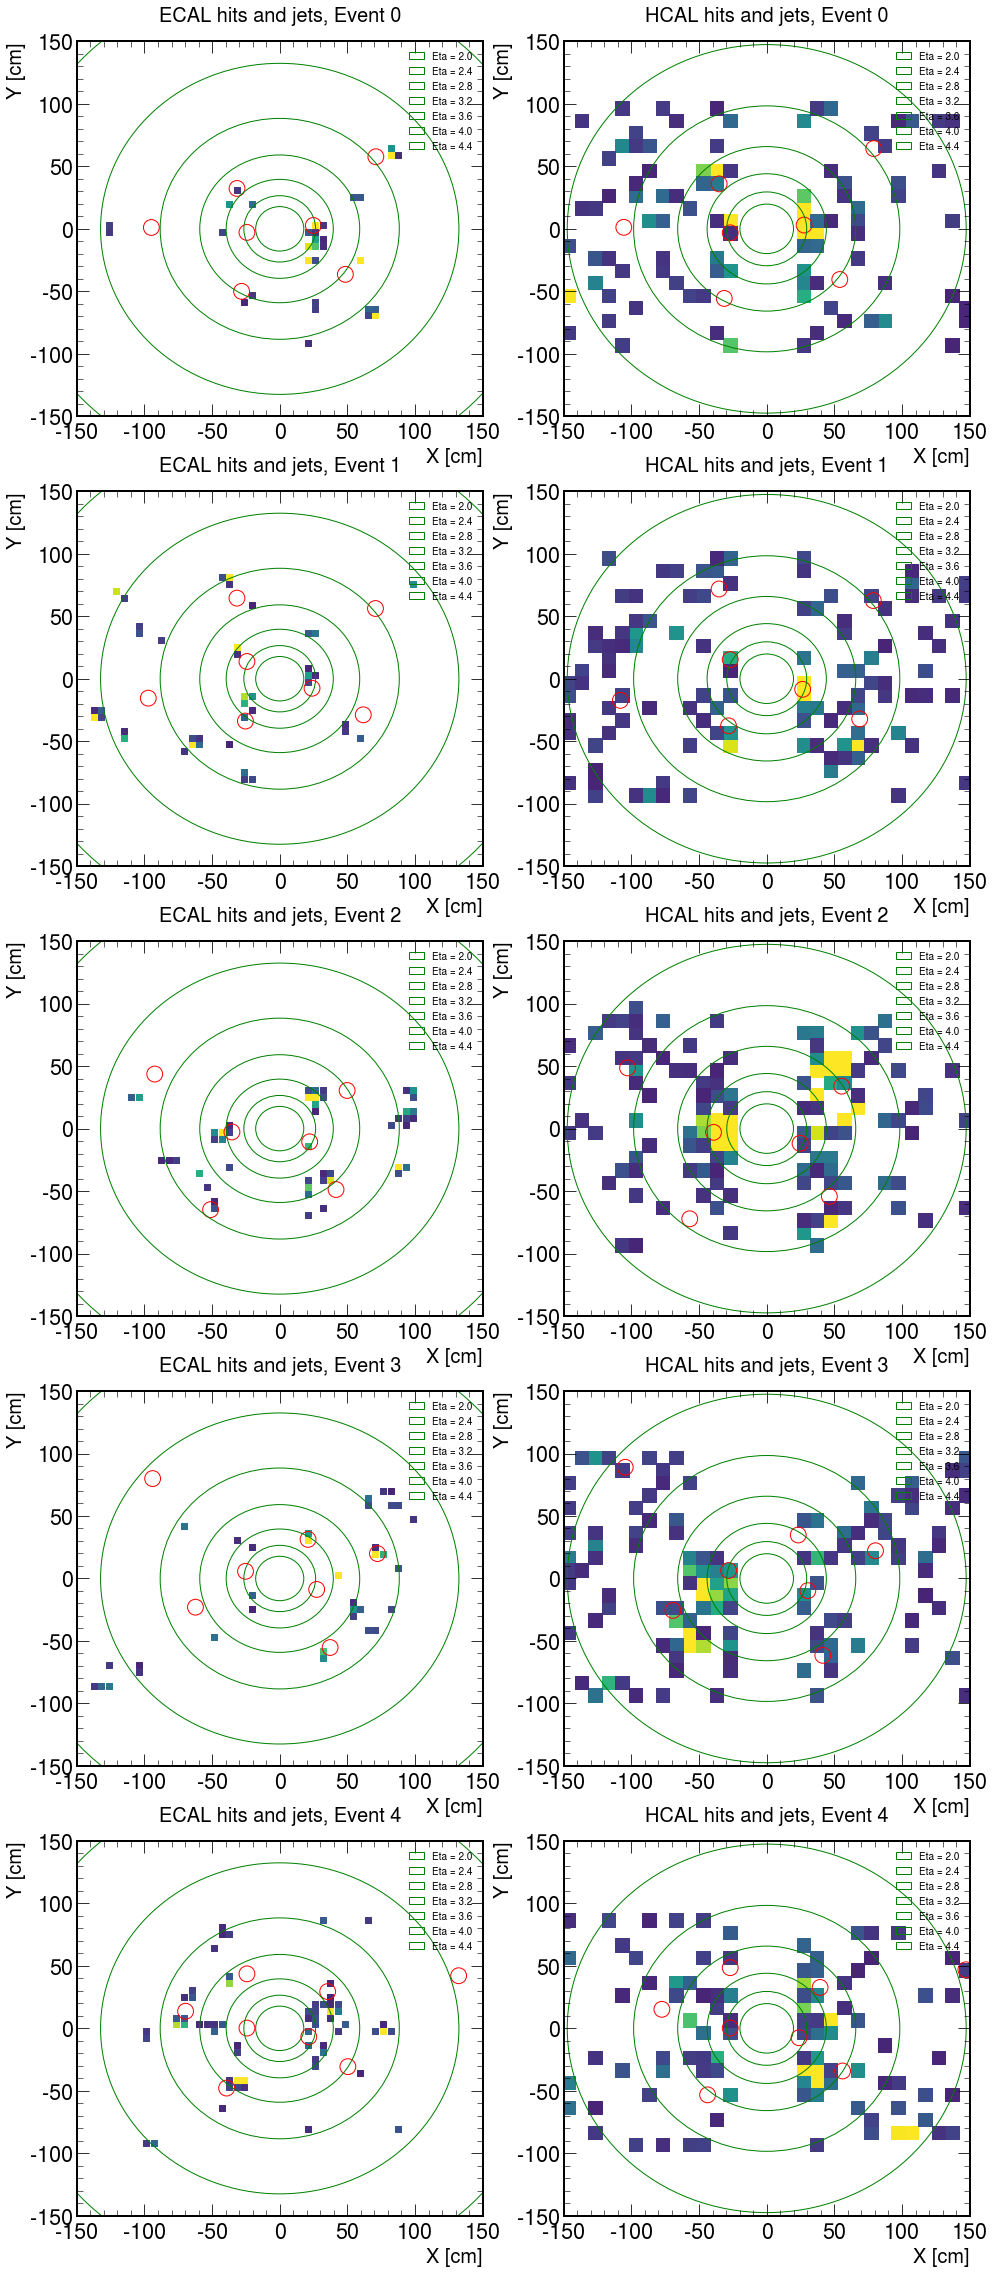

In [10]:
from matplotlib.patches import Circle

n = 5

fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(16, 8*n), gridspec_kw={'hspace': 0.2})

inferno = plt.get_cmap('viridis')
cmap = plt.get_cmap('viridis')

for i in range(n):
    
    evt = highJet[i]
    
    ax = axs[i][0]
    ax.set_title(f'ECAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.scatter(np.array(xEcal[evt]), np.array(yEcal[evt]), marker = 's', color=[cmap(k) for k in np.array(eEcal[evt])])

    

    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)


    for j in range(20, 48, 4):
        j = j / 10.0
        R = inverse_eta(j,724)
        color = ((1 - (j-2))/2, 0, (j-2)/2)
        circle = Circle((0, 0), R, color='g', fill=False, label = f'Eta = {j}')
        axs[i,0].add_patch(circle)  
   
    handles, labels = axs[i,0].get_legend_handles_labels()

    
    axs[i,0].legend(handles, labels, loc='upper right',fontsize=10)
 
    axs[i,0].set_ylim(-150,150)
    axs[i,0].set_xlim(-150,150)
    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXE[evt][j]
        y_pos = jetYE[evt][j]

        ax.scatter(x_pos, y_pos, s=250, facecolors='none', edgecolors='r')

    
    
    ax = axs[i][1]
    ax.set_title(f'HCAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.scatter(np.array(xHcal[evt]), np.array(yHcal[evt]), s=180, marker='s', color=[cmap(k) for k in np.array(eHcal[evt])])

    axs[i,1].set_ylim(-150,150)
    axs[i,1].set_xlim(-150,150)
    
    for j in range(20, 48, 4):
        j = j / 10.0
        R = inverse_eta(j,806)
        color = ((1 - (j-2))/2, 0, (j-2)/2)
        circle = Circle((0, 0), R, color='g', fill=False, label = f'Eta = {j}')
        axs[i,1].add_patch(circle) 
   
    handles, labels = axs[i,1].get_legend_handles_labels()

    axs[i,1].legend(handles, labels, loc='upper right', fontsize=10)

    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)

    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXH[evt][j]
        y_pos = jetYH[evt][j]
        ax.scatter(x_pos, y_pos, s=250, facecolors='none', edgecolors='r')

plt.tight_layout()



Text(0.5, 1.0, 'Jet Multiplicity')

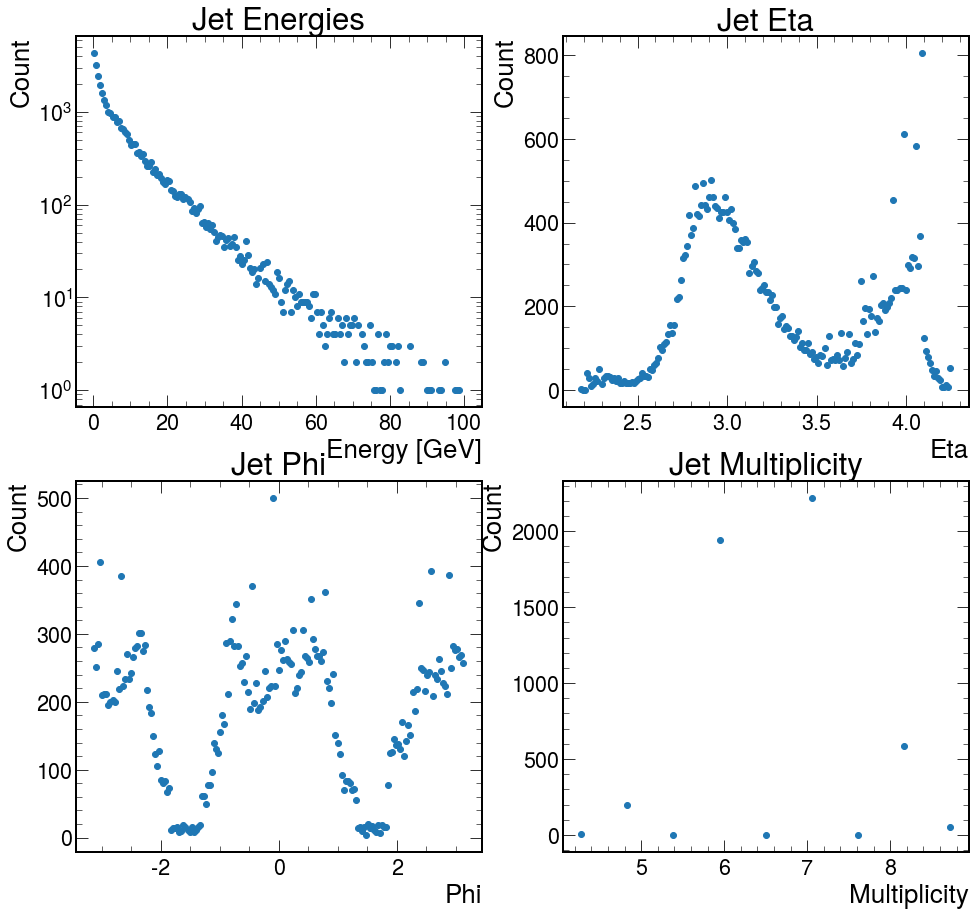

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'hspace': 0.2})


plt.sca(axs[0][0])
ax.set_title("Jet Energies", fontsize=20, pad=20)

hist, bin_edges = np.histogram(ak.flatten(jetE),range=(0,100),bins=round(np.sqrt(len(ak.flatten(jetE)))))
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_centres,hist)
plt.yscale("log")
plt.xlabel('Energy [GeV]')
plt.ylabel('Count')
plt.title("Jet Energies")

plt.sca(axs[0][1])
ax.set_title("Jet Eta", fontsize=20, pad=20)

hist, bin_edges = np.histogram(ak.flatten(jetEta),bins=round(np.sqrt(len(ak.flatten(jetEta)))))
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_centres,hist)

plt.xlabel('Eta')
plt.ylabel('Count')
plt.title("Jet Eta")


plt.sca(axs[1][0])


hist, bin_edges = np.histogram(ak.flatten(jetPhi),bins=round(np.sqrt(len(ak.flatten(jetPhi)))))
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_centres,hist)

plt.xlabel('Phi')
plt.ylabel('Count')
plt.title("Jet Phi")

def get_multiplicity(data):
    return ak.Array([len(subarray) for subarray in data])

plt.sca(axs[1][1])


hist, bin_edges = np.histogram(get_multiplicity(jetE),bins=max(get_multiplicity(jetE)))
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_centres,hist)

plt.xlabel('Multiplicity')
plt.ylabel('Count')
plt.title("Jet Multiplicity")


Text(0.5, 1.0, 'Event 3, R=1.0')

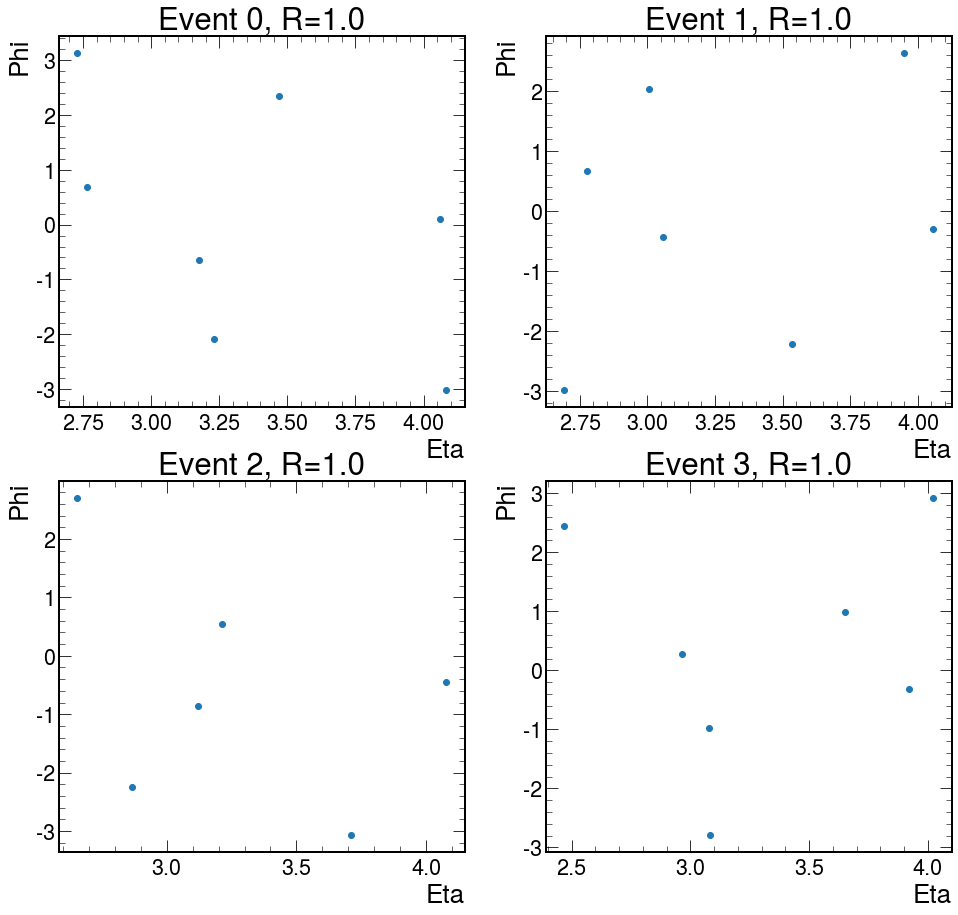

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'hspace': 0.2})
R=0.4
plt.sca(axs[0][0])
evt = 0
      
plt.scatter(jetEta[evt],jetPhi[evt])
#circle1 = plt.Circle((0, 0), 0.4, color='r')
#axs[0][0].add_patch(circle1)

plt.xlabel("Eta")
plt.ylabel("Phi")
plt.title("Event 0, R=1.0")

plt.sca(axs[0][1])
evt = 1
plt.scatter(jetEta[evt],jetPhi[evt])
plt.xlabel("Eta")
plt.ylabel("Phi")
plt.title("Event 1, R=1.0")

plt.sca(axs[1][0])
evt = 2
plt.scatter(jetEta[evt],jetPhi[evt])
plt.xlabel("Eta")
plt.ylabel("Phi")
plt.title("Event 2, R=1.0")

plt.sca(axs[1][1])
evt = 3
plt.scatter(jetEta[evt],jetPhi[evt])
plt.xlabel("Eta")
plt.ylabel("Phi")
plt.title("Event 3, R=1.0")